In [3]:
import pandas as pd
import numpy as np
import os
import trajectory_planning_helpers as tph
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from f1tenth_benchmarks.utils.MapData import MapData
from f1tenth_benchmarks.data_tools.plotting_utils import *
from f1tenth_benchmarks.data_tools.process_data import process_data


if os.getcwd().split('/')[-1] == 'benchmark_results':
    os.chdir('..')
    os.chdir('..')
    print(f'Changed directory to root of repo: {os.getcwd()}')

save_path = 'Data/BenchmarkArticle/'
if not os.path.exists(save_path):
    os.makedirs(save_path)

process_data()

Complied Full.csv and Summary.csv.


/tmp/ipykernel_520370/2116532392.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


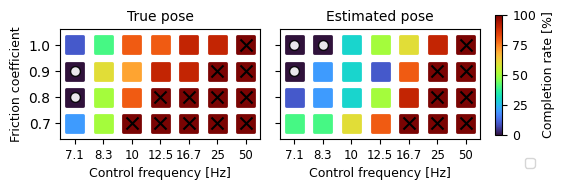

In [9]:
timesteps = [2, 4, 6, 8, 10, 12, 14]
friction_vals = [0.7, 0.8, 0.9, 1]
map_name = "aut"
planner_names = ["GlobalPlanPP", "FullStackPP300"]
plot_titles = ["True pose", "Estimated pose"]

block_size = 150
summary_df = pd.read_csv("Logs/Summary.csv")

summary_df = summary_df[summary_df.Vehicle.isin(planner_names)]
test_ids = summary_df["TestID"].str.split("_", expand=True)
summary_df["mu"] = test_ids[0].str[2:].astype(float) / 100
timestep_series = test_ids[1].str[5:]
timestep_series.dropna(inplace=True)
summary_df["simulator_timestep"] = timestep_series.astype(int)
summary_df["CompletionRate"] *= 100

summary_df = summary_df[summary_df["simulator_timestep"].isin(timesteps)]
summary_df = summary_df[summary_df["mu"].isin(friction_vals)]
summary_df = summary_df[summary_df["MapName"] == map_name]

fig, axs = plt.subplots(1, 2, figsize=(5, 2.), sharex=True, sharey=True)

for i in range(len(planner_names)):
    data = summary_df[summary_df["Vehicle"] == planner_names[i]]
    color_axis = axs[i].scatter(data["simulator_timestep"], data["mu"], s=block_size, c=data["CompletionRate"], marker='s', linewidth=2, cmap='turbo', vmin=0, vmax=100)
    complete_df = data.loc[data.CompletionRate >= 99]
    axs[i].scatter(complete_df["simulator_timestep"], complete_df["mu"], s=block_size/2, c='k', marker='x')
    uncomplete_df = data.loc[data.CompletionRate <= 1]
    axs[i].scatter(uncomplete_df["simulator_timestep"], uncomplete_df["mu"], s=block_size/3, edgecolors='k', marker='o', alpha=0.9, facecolor='w')
    axs[i].set_title(plot_titles[i], size=10)
    axs[i].set_xlabel("Control frequency [Hz]", size=9)
    axs[i].set_xticks([2, 4, 6, 8, 10, 12, 14])
    axs[i].set_xticklabels([50, 25, 16.7, 12.5, 10, 8.3, 7.1], fontsize=8.5)
    axs[i].set_xlim(15, 1)

ax = plt.gca()
cax = fig.add_axes([ax.get_position().x1+0.1, ax.get_position().y0+0.19, 0.015, ax.get_position().height*0.78])
cbar = plt.colorbar(color_axis, cax=cax)
cbar.set_label("Completion rate [%]", size=9)
cbar.ax.tick_params(labelsize=9)

axs[0].set_ylabel("Friction coefficient", size=9)
axs[0].set_ylim(0.64, 1.06)
axs[0].yaxis.set_major_locator(plt.MaxNLocator(5))

plt.tight_layout()
axs[1].legend(loc='center', bbox_to_anchor=(1.25, -0.22), fontsize=9)

plt.savefig(save_path + "FrequencyFrictionCompletionRate.svg", bbox_inches='tight')
plt.savefig(save_path + "FrequencyFrictionCompletionRate.pdf", bbox_inches='tight')


i: 0 - timestep: mu70_steps2
i: 1 - timestep: mu100_steps2


/tmp/ipykernel_520370/4057134448.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


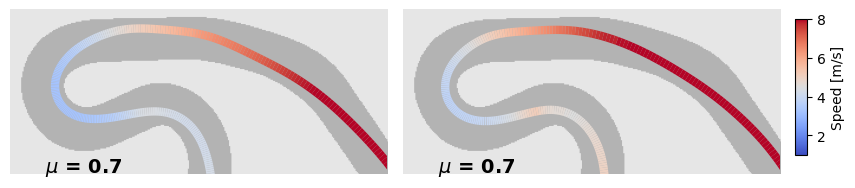

In [11]:
planner = "FullStackPP"
mu_vals = [0.7, 1.0]
test_ids = [f"mu{int(mu*100)}_steps2" for mu in mu_vals]
plot_map = "gbr"
lap_n = 0

lap_dfs = []
for i, test_id in enumerate(test_ids):
    data = np.load(f"Logs/{planner}/RawData_{test_id}/SimLog_{plot_map}_{lap_n}.npy")[1:, :] #remove first repeated entry
    df = pd.DataFrame(data, columns=["x", "y", "steer", "speed", "yaw", "yaw_rate", "slip", "steer_a", "speed_a", "progress"])
    df["test_id"] = test_id
    lap_dfs.append(df)

lap_df = pd.concat(lap_dfs)
lap_df.dropna(inplace=True)


map_data = MapData(plot_map)
fig, axs = plt.subplots(1, len(test_ids), figsize=(8, 2.5), sharex=True, sharey=True)
for i in range(len(test_ids)):
    print(f"i: {i} - timestep: {test_ids[i]}")
    plt.sca(axs[i])
    map_data.plot_map_img()

    df = lap_df[lap_df['test_id'] == test_ids[i]]

    xs, ys = map_data.xy2rc(df.x, df.y)
    pts = np.array([xs, ys]).T.reshape(-1, 1, 2)
    segments = np.concatenate([pts[:-1], pts[1:]], axis=1)
    norm = plt.Normalize(1, 8)
    lc = LineCollection(segments, cmap='coolwarm', norm=norm)
    lc.set_array(df.speed.values)
    lc.set_linewidth(6)
    line = plt.gca().add_collection(lc)
    
    plt.axis('off')
    axs[i].set_aspect('equal')
    plt.xlim(840, 1160)
    plt.ylim(720, 860)

    axs[i].text(870, 722, f"$\mu$ = {mu_vals[0]}", fontsize=14, fontdict={'weight': 'bold'})

ax = plt.gca()
cax = fig.add_axes([ax.get_position().x1+0.1, ax.get_position().y0, 0.015, ax.get_position().height*1.1])
plt.colorbar(line, cax=cax, label="Speed [m/s]", ticks=[2, 4, 6, 8])
plt.tight_layout()

plt.savefig(f"{save_path}trajectory_mu_comparison_{map_name}.pdf", bbox_inches='tight')

In [2]:
planner = "FullStackPP"
mu_vals = [1, 0.7]
# mu_vals = [0.7, 1.0]
test_ids = [f"mu{int(mu*100)}_steps2" for mu in mu_vals]
plot_map = "gbr"
lap_n = 0

lap_dfs = []
for i, test_id in enumerate(test_ids):
    data = np.load(f"Logs/{planner}/RawData_{test_id}/SimLog_{plot_map}_{lap_n}.npy")[1:, :] #remove first repeated entry
    df = pd.DataFrame(data, columns=["x", "y", "steer", "speed", "yaw", "yaw_rate", "slip", "steer_a", "speed_a", "progress"])
    df["test_id"] = test_id
    lap_dfs.append(df)

lap_df = pd.concat(lap_dfs)
lap_df.dropna(inplace=True)

colors = [periwinkle, red_orange]
fig, axs = plt.subplots(1, 1, figsize=(6, 1.8), sharex=True, sharey=False)
for i in range(len(test_ids)):
    print(f"i: {i} - timestep: {test_ids[i]}")

    df = lap_df[lap_df['test_id'] == test_ids[i]]
    plt.plot(df.progress.values*100, df.speed.values, label=f"$\mu$ = {mu_vals[i]}", linewidth=2, color=colors[i])

plt.legend(ncol=2, fontsize=9)
plt.ylim(3, 8.5)
plt.grid()
plt.xlabel("Progress [%]")
plt.ylabel("Speed [m/s]")
plt.tight_layout()

plt.savefig(f"{save_path}speed_friction_comparison_{map_name}.pdf", bbox_inches='tight')



FileNotFoundError: [Errno 2] No such file or directory: 'Logs/FullStackPP/RawData_mu100_steps2/SimLog_gbr_0.npy'

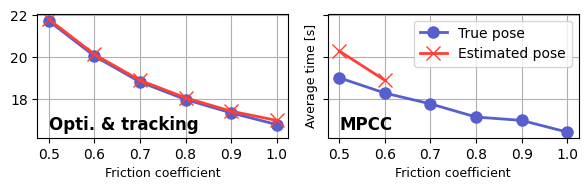

In [38]:
friction_vals = [0.5, 0.6, 0.7, 0.8, 0.9, 1]
map_name = "aut"
planners = ["PP", "MPCC"]
modes = ["GlobalPlan", "FullStack"]
# plot_titles = ["True pose", "Estimated pose"]
planner_names = [f"{mode}{planner}" for mode in modes for planner in planners]
timesteps = [4]


block_size = 150
summary_df = pd.read_csv("Logs/Summary.csv")
summary_df = summary_df[summary_df.MapName == map_name]

pp_df = summary_df[summary_df.Vehicle.str.contains("PP")]
pp_df = pp_df[pp_df.TestID.str[:2] == "mu"]
test_ids = pp_df["TestID"].str.split("_", expand=True)
pp_df["mu"] = test_ids[0].str[2:].astype(float) / 100
timestep_series = test_ids[1].str[5:]
timestep_series.dropna(inplace=True)
pp_df["simulator_timestep"] = timestep_series.astype(int)
pp_df["CompletionRate"] *= 100
pp_df = pp_df[pp_df["simulator_timestep"].isin(timesteps)]

mpcc_df = summary_df[summary_df.Vehicle.str.contains("MPCC")]
mpcc_df = mpcc_df[mpcc_df.TestID.str[:4] == "mpcc"]
test_ids = mpcc_df["TestID"].str.split("_", expand=True)
mpcc_df["mu"] = test_ids[1].str[2:].astype(float) / 100
mpcc_df["CompletionRate"] *= 100


fig, axs = plt.subplots(1, 2, figsize=(6, 2.), sharex=True, sharey=True)

plt.sca(axs[0])
plan_pp_df = pp_df[pp_df["Vehicle"] == "GlobalPlanPP"].sort_values(by="mu")
plt.plot(plan_pp_df["mu"], plan_pp_df["AvgTime"], '-o', label="True pose", linewidth=2, color=periwinkle, markersize=8)
full_pp_df = pp_df[pp_df["Vehicle"] == "FullStackPP"].sort_values(by="mu")
plt.plot(full_pp_df["mu"], full_pp_df["AvgTime"], '-x', label="Estimated pose", linewidth=2, color=red_orange, markersize=10)

plt.xlabel("Friction coefficient", size=9)
# plt.ylabel("Average time [s]", size=9)
plt.grid()
plt.text(0.5, 16.5, "Opti. & tracking", fontsize=12, fontdict={'weight': 'bold'})

plt.sca(axs[1])
plan_mpcc_df = mpcc_df[mpcc_df["Vehicle"] == "GlobalPlanMPCC"].sort_values(by="mu")
plt.plot(plan_mpcc_df["mu"], plan_mpcc_df["AvgTime"], '-o', label="True pose", linewidth=2, color=periwinkle, markersize=8)
full_mpcc_df = mpcc_df[mpcc_df["Vehicle"] == "FullStackMPCC"].sort_values(by="mu")
plt.plot(full_mpcc_df["mu"], full_mpcc_df["AvgTime"], '-x', label="Estimated pose", linewidth=2, color=red_orange, markersize=10)
plt.grid()

plt.xlabel("Friction coefficient", size=9)
plt.ylabel("Average time [s]", size=9)
plt.text(0.5, 16.5, "MPCC", fontsize=12, fontdict={'weight': 'bold'})

plt.tight_layout()
# plt.legend(loc='center', bbox_to_anchor=(0.5, 1.22), fontsize=9, ncol=2)
plt.legend()

plt.savefig(save_path + "FrictionTimeComparison.svg", bbox_inches='tight')

